Utilisation du KNN sur un jeu de données ou l'image est cadrée en 128px par 128px avec un traitement hog

Installation des requirements

In [2]:
! pip install --no-cache-dir -r requirement.txt

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirement.txt'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Import des librairies nécessaires

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
import seaborn as sns

Création du Dataset panda d'après le fichier "data.csv"

In [4]:
data_1				= pd.read_csv("data_128x128_hog.csv", sep = ";")
#print(data_1.shape)

Certaines classes posent problème car elles sont identifiée à tort par le classiffieur de trop nombreuses fois, On les retire donc ici

In [5]:
data                = data_1[data_1["Target"] != 29]
data                = data[data["Target"] != 28]
data                = data[data["Target"] != 24]
data                = data[data["Target"] != 18]
#print(data.shape)
#print(data_1.shape[0]- data.shape[0])

Définition des variables explicatives ( x ) et des targets ( y ) puis séparation en jeux de données de test et d'entrainement

In [6]:
x					= data.iloc[:,2:].values
#print(x.shape)
y					= data.iloc[:,1].values
#print(y.shape)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2) #20% pour test, 80% pour entrainement

Création du model et de la validation curve avec l'emploi d'une cross-validation qui permet de séparer le jeu de données en plusieurs parties puis d'entrainer et évaluer le modèle avec chaque partie afin de déterminer laquelle donne le meilleur résultat

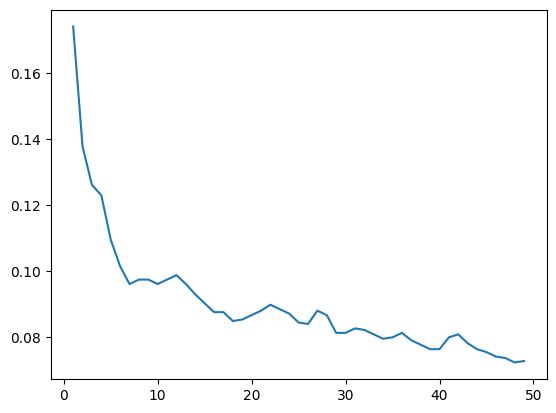

In [7]:
model = KNeighborsClassifier()
k = np.arange(1,50)

train_score, val_score = validation_curve(model, x_train, y_train, param_name='n_neighbors', param_range= k, cv = 5)

plt.plot(k, val_score.mean(axis=1))

On peut voir grâce à cette courbe de validation que le modèle n'est pas plus performant si l'on augmente le nombre de k voisins

Utilisation de GridSearch afin de tester de manière exhaustive tous les hyperparamètres ( à la manière d'une Cross-Validation) afin d'évaluer quelle est la meilleure combinaison d'hyperparamètres

In [8]:
param_grid = {'n_neighbors' : np.arange(1, 20), 'metric' : ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5)

grid.fit(x_train, y_train)



GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

Affichage des hyperparamètres avec les meilleurs résultats

In [9]:
grid.best_score_

0.18132412959137403

In [10]:
grid.best_params_


{'metric': 'manhattan', 'n_neighbors': 1}

In [11]:
model = grid.best_estimator_

Affichage des scores et d'une matrice de confusion retranscrite sur une heatmap

In [12]:
model.score(x_test, y_test)

0.18312387791741472

In [13]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred )

<Axes: >

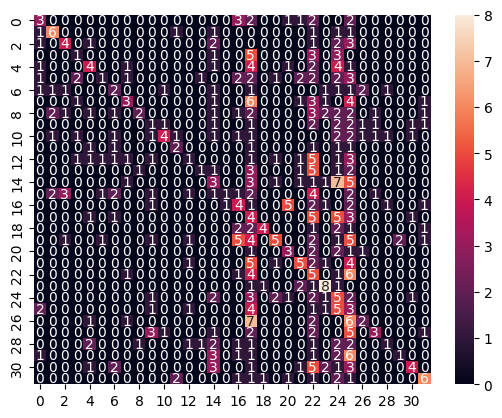

In [14]:
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot= True)


On voit bien sur cette matrice de confusion que le classifieur a tendance à reconnaitre une classe ( ici la 25) et à se tromper, cet effet se retrouvait de manière plus intense sur les classes retirées du jeu de données 

In [15]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.27      0.21      0.24        14
           2       0.50      0.50      0.50        12
           3       0.40      0.29      0.33        14
           4       0.17      0.08      0.11        13
           5       0.31      0.21      0.25        19
           6       0.25      0.05      0.08        20
           7       0.18      0.14      0.16        14
           8       0.33      0.14      0.20        21
           9       0.50      0.09      0.15        22
          10       0.09      0.07      0.08        14
          11       0.57      0.20      0.30        20
          12       0.33      0.25      0.29         8
          13       0.17      0.05      0.08        19
          14       0.33      0.07      0.11        15
          15       0.12      0.13      0.12        23
          16       0.50      0.05      0.08        22
          17       0.17      0.21      0.19        19
          19       0.05    

[ 178  356  534  712  891 1069 1247 1425 1603 1782]


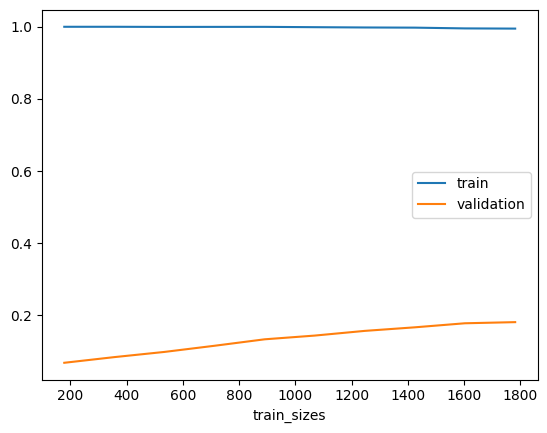

In [16]:
N, train_score_lc, val_score_lc = learning_curve(model, x_train, y_train, train_sizes = np.linspace(0.1, 1.0, 10), cv = 5)

print(N)
plt.plot(N, train_score_lc.mean(axis=1), label = 'train' )
plt.plot(N, val_score_lc.mean(axis=1), label = 'validation' )
plt.xlabel('train_sizes')
plt.legend()

D'après la learning curve ci-dessus, le score d'entrainement est élevé alors que le score de validation est bas, ce qui signifie que notre modèle est en suraprentissage et qu'il n'est donc pas forcément adapté a notre jeu de donnée